# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [78]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

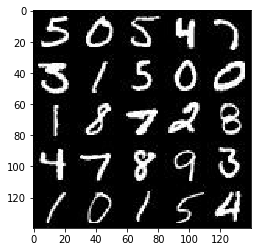

In [79]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

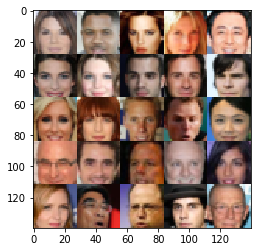

In [80]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [81]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [82]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [83]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input images are 28x28x3, input layer does not have batch normalization and we pass it to get a leaky relu output
        # This will become 14x14x64 when we pass in 64 filters 
        #alpha  = 0.01
        alpha = 0.2
        #Note: I have experimented with the xavier_initializer for the kernel_init below, to see if the losses eventually get better..
        #x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        
        #All hidden layers will be of the form: convolution > batch norm > leaky ReLU
        #x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm_layer_2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*batch_norm_layer_2, batch_norm_layer_2) #7x7x128
        
        #All hidden layers will be of the form: convolution > batch norm > leaky ReLU
        #x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm_layer_3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*batch_norm_layer_3, batch_norm_layer_3) #4x4x256
        
        #Now we need to flatten it, no batch normalization here.. 
        flatten_result = tf.reshape(relu3, (-1, 4*4*256))
        #flatten_result = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flatten_result, 1)
        #Add dropout --> DIdn't work as made results worse and also increased training time.. 
        #logits = tf.layers.dropout(logits, rate=0.5)
        output = tf.sigmoid(logits)
        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [84]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #alpha = 0.01
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        #First fully connected layer . No batch normalization here. 
        x1 = tf.layers.dense(z, 7*7*512)

        # We need to reshape this into something like a 7x7x512, this is just inspired from the dcgan project/dcgan paper where they used 4x4x512. Since the image size here is 28x28 I am using 7x7 for the first connected layer
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        batch_normalization_1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * batch_normalization_1, batch_normalization_1) 

        #Layer 2, with a combination of conv > batch_norm > relu ---> gives an output of shape 7x7x256 (stride is just 1)
        #x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_normalization_2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * batch_normalization_2, batch_normalization_2) 

        #Layer 3, with a combination of conv > batch_norm > relu ---> gives an output of shape 14x14x128 (stride is changed)
        #x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_normalization_3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * batch_normalization_3, batch_normalization_3) 

        #x4 is an experiment to add one more convd to give the generator an advantage.
        #x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=1, padding='same')
        #batch_normalization_4 = tf.layers.batch_normalization(x4, training=is_train)
        #relu4 = tf.maximum(alpha * batch_normalization_4, batch_normalization_4) 
        # Output layer will be 28x28xout_channel_dim, so we definitely have to transpose our output from previous layer into this shape/dimensions. No batch normalization. 
        #experiment here:
        #logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=2, padding='same') #28x28xoutput_channel_dim now
        #logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same') #28x28xoutput_channel_dim now
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        output = tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [85]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Get the output of the generator which is the fake input to discriminator later
    generator_model = generator(input_z, out_channel_dim)
    #Get the output of discriminator with the real input passed above
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    #Get the output of discriminator with the fake input from the generator
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    #Compute real loss 
    alpha = 0.8999 # Random number picked for smoothening, ideally wanted it somewhere around ~0.9
    discriminator_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)*alpha))
    #Compute fake loss
    discriminator_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    #Compute generator loss
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))
    
    #The ultimate discriminator loss is the sum of the fake and real losses
    
    discriminator_loss = discriminator_fake_loss + discriminator_real_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [86]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]  
    #optimize it now
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_training_optimize = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        generator_training_optimize = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        #generator_training_optimize = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return discriminator_training_optimize, generator_training_optimize


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [87]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [89]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape [2]
    image_channels = data_shape[3]
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    #print("image_width:".format(image_width))
   # print("image_height:".format(image_height))
   # print("image_channels:".format(image_channels))
   # print("Data shape:")
   # print(data_shape)
    discriminator_loss, generator_loss=  model_loss(inputs_real, inputs_z, image_channels)
    discriminator_training_optimize, generator_training_optimize = model_opt(discriminator_loss, generator_loss, lr, beta1)
    # TODO: Build Model
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2 #Because we are using tanh for the generator, it is *2 that of sigmoid
                #Sample noise
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(discriminator_training_optimize, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(generator_training_optimize, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                
                if (steps %10 == 0) :
                    train_loss_discriminator = discriminator_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_generator = generator_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_discriminator),
                          "Generator Loss: {:.4f}".format(train_loss_generator))
                    # Save losses to view after training
                   # losses.append((train_loss_d, train_loss_g))
                    
                if ((steps % 100) == 0) :
                    show_generator_output(sess, show_n_images, inputs_z, image_channels, data_image_mode)      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 2.0087
Epoch 1/2... Discriminator Loss: 1.9461... Generator Loss: 1.3857
Epoch 1/2... Discriminator Loss: 2.4056... Generator Loss: 0.2960
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.5260
Epoch 1/2... Discriminator Loss: 2.5036... Generator Loss: 0.2249
Epoch 1/2... Discriminator Loss: 2.3418... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 2.1136... Generator Loss: 0.2567
Epoch 1/2... Discriminator Loss: 1.5647... Generator Loss: 0.5264
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.8167


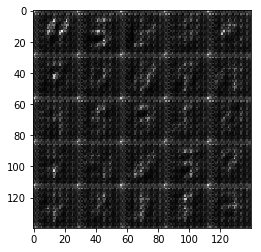

Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 1.4420
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 1.3620
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 0.8422
Epoch 1/2... Discriminator Loss: 1.9564... Generator Loss: 0.2858
Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.4480


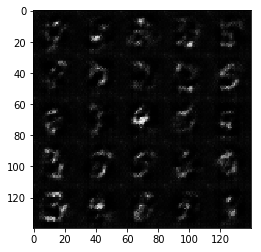

Epoch 1/2... Discriminator Loss: 1.6944... Generator Loss: 0.3646
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 1.2415
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.6040


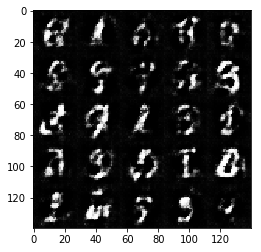

Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 1.4318
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.9958
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 1.5033
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.4819
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 1.5949
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.5284


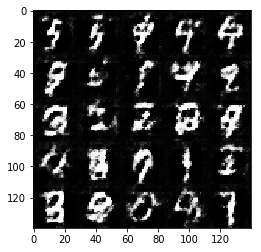

Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 1.4822
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 1.0156
Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 0.5501
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 1.6454
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.5413
Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 1.7687
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.7028
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.2912... Generator Loss: 0.6410


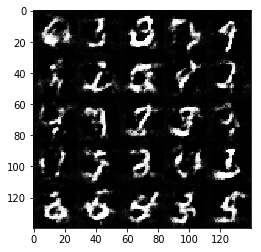

Epoch 1/2... Discriminator Loss: 1.5947... Generator Loss: 0.3623
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 1.4338
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.5354
Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 1.3467


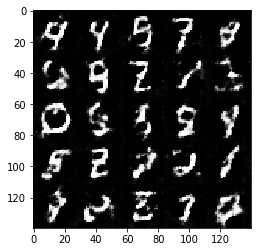

Epoch 1/2... Discriminator Loss: 1.5034... Generator Loss: 0.4452
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.5964
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.6596... Generator Loss: 0.3717
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 0.7736
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 0.8631


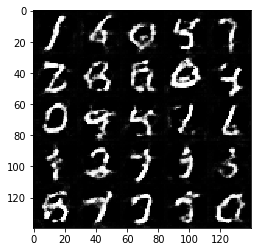

Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.2112
Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 1.0989
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 1.4044
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.8491
Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 1.1382
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.4774


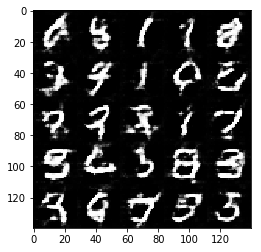

Epoch 1/2... Discriminator Loss: 1.6800... Generator Loss: 0.3632
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.2319... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.8545
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.5865
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.5855
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 0.8353


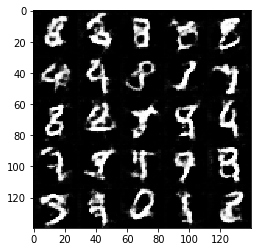

Epoch 1/2... Discriminator Loss: 1.2066... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 0.9429... Generator Loss: 1.1500
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.3835
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.6707
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 1.5162
Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 1.1538


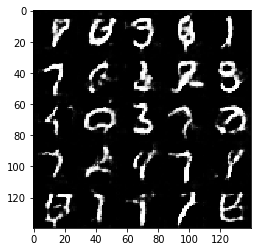

Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 1.3307
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.5322
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 1.1929
Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 2.2456
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 1.0912
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.8263


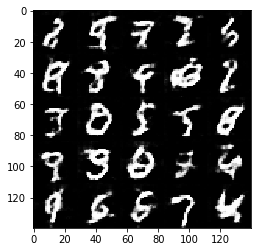

Epoch 1/2... Discriminator Loss: 1.6444... Generator Loss: 0.4379
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 1.3285
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.5875
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.9824
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.5871
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.2842
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 1.0510
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.7181


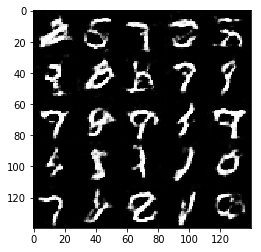

Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 1.3877
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 0.9085
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 1.2009
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 1.4681
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 1.2806
Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.5819
Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 1.0958
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 0.8719


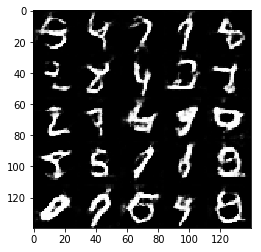

Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 0.8504
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 0.8092
Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 2.3176
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.2433


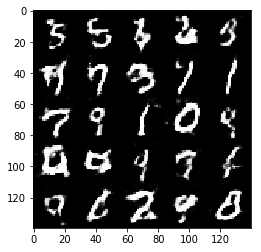

Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 1.0254
Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.2065
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.1231
Epoch 1/2... Discriminator Loss: 0.7385... Generator Loss: 1.7752
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.5260
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 0.9573... Generator Loss: 0.9243
Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 1.6099


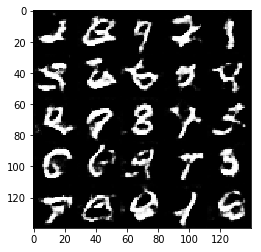

Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 0.8149
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.5666
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 1.6002
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 2.7405
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.0349


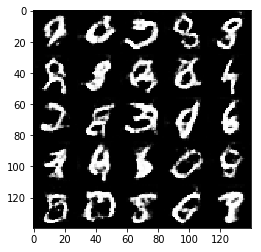

Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 0.8432
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 1.9410
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 0.9599
Epoch 1/2... Discriminator Loss: 0.8025... Generator Loss: 1.2629
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 1.8464... Generator Loss: 0.3081
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 0.9334
Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 1.4859


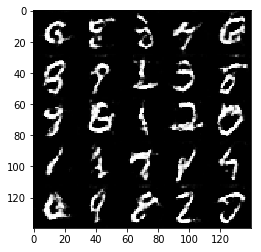

Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.5874
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.5210
Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 2.1259
Epoch 1/2... Discriminator Loss: 0.8567... Generator Loss: 1.1841
Epoch 1/2... Discriminator Loss: 0.8038... Generator Loss: 1.1896
Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 1.2496


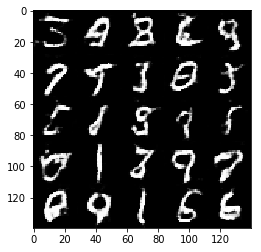

Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.6389
Epoch 1/2... Discriminator Loss: 1.6529... Generator Loss: 0.3436
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.3376
Epoch 1/2... Discriminator Loss: 1.2137... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 1.3325
Epoch 1/2... Discriminator Loss: 0.6184... Generator Loss: 1.8088
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 0.7896


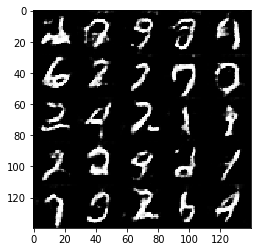

Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 0.6693... Generator Loss: 1.5103
Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 1.2457
Epoch 1/2... Discriminator Loss: 1.6146... Generator Loss: 0.3898
Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 1.4146
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.7301
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.1675
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.8653


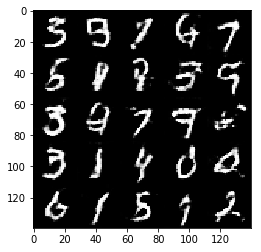

Epoch 1/2... Discriminator Loss: 0.9301... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.1666
Epoch 1/2... Discriminator Loss: 0.7024... Generator Loss: 1.3929
Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.7250


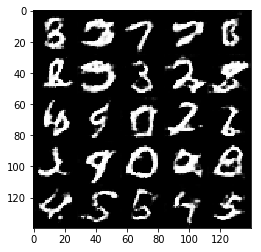

Epoch 1/2... Discriminator Loss: 0.9295... Generator Loss: 1.0437
Epoch 1/2... Discriminator Loss: 0.6947... Generator Loss: 1.5862
Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 2.3465
Epoch 1/2... Discriminator Loss: 2.1931... Generator Loss: 3.0710
Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 2.4509
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.5912
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.7514


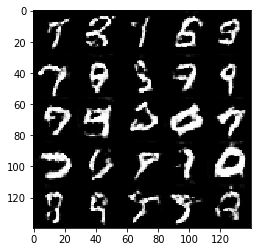

Epoch 1/2... Discriminator Loss: 1.5931... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 2.4184
Epoch 1/2... Discriminator Loss: 0.7025... Generator Loss: 1.8124
Epoch 1/2... Discriminator Loss: 2.1355... Generator Loss: 0.3007
Epoch 1/2... Discriminator Loss: 1.0762... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 1.5276
Epoch 1/2... Discriminator Loss: 0.8857... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 1.2880
Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.3971
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.8003


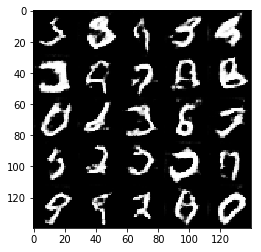

Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 1.5685
Epoch 1/2... Discriminator Loss: 1.6864... Generator Loss: 0.4727
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 1.3930
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.5516
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 1.4031
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 1.1639


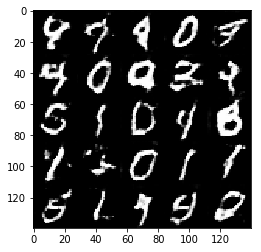

Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 1.6329
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.7793
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.3593
Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 1.2489
Epoch 1/2... Discriminator Loss: 0.6005... Generator Loss: 1.6596
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 1.7940
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 1.2508
Epoch 1/2... Discriminator Loss: 0.7638... Generator Loss: 1.3933


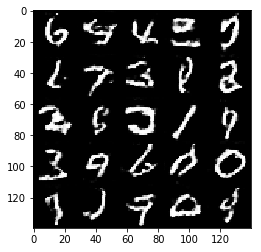

Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 1.1177
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.7996
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 1.2014
Epoch 1/2... Discriminator Loss: 0.7603... Generator Loss: 1.3894
Epoch 1/2... Discriminator Loss: 0.6323... Generator Loss: 1.7779
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 1.3449
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.1516
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 2.9481


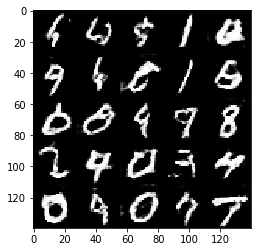

Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.6090
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 2.5759
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.6268
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.4797
Epoch 1/2... Discriminator Loss: 0.8187... Generator Loss: 1.1815
Epoch 1/2... Discriminator Loss: 0.8159... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 0.9539
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.8834


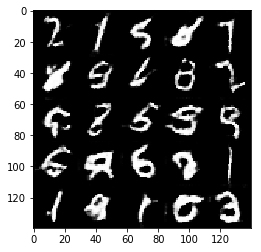

Epoch 1/2... Discriminator Loss: 0.7380... Generator Loss: 1.3304
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 0.9693
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.1455
Epoch 1/2... Discriminator Loss: 0.5892... Generator Loss: 1.7510
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.3411
Epoch 1/2... Discriminator Loss: 1.0368... Generator Loss: 0.8168
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.5988
Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.1476
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 1.2606


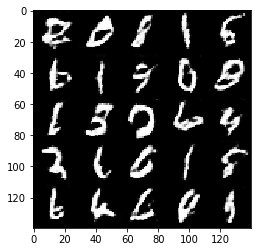

Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.3790
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.5474
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.6712
Epoch 1/2... Discriminator Loss: 0.4786... Generator Loss: 2.4163
Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 0.8893
Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 1.5175
Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 1.4545
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.6735
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 1.7040


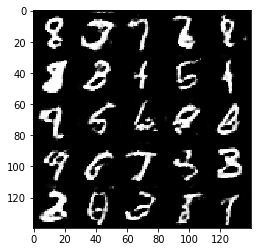

Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 0.8525
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 1.4437
Epoch 1/2... Discriminator Loss: 0.6147... Generator Loss: 2.2978
Epoch 1/2... Discriminator Loss: 0.6570... Generator Loss: 1.6291
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 1.9629
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 1.2095
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 1.8300


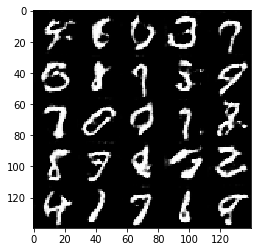

Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 1.2841
Epoch 1/2... Discriminator Loss: 3.1113... Generator Loss: 0.1154
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 2.0272
Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 1.0276
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 1.1336
Epoch 1/2... Discriminator Loss: 0.6105... Generator Loss: 1.7435
Epoch 1/2... Discriminator Loss: 0.8440... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 1.1543
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 1.0778
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 0.7925


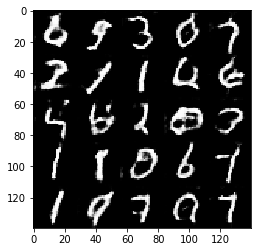

Epoch 1/2... Discriminator Loss: 0.6734... Generator Loss: 1.7164
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.1852
Epoch 1/2... Discriminator Loss: 0.6406... Generator Loss: 1.9613
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 1.3462
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.2116
Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 0.7664... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 0.9717
Epoch 1/2... Discriminator Loss: 1.7287... Generator Loss: 0.3901


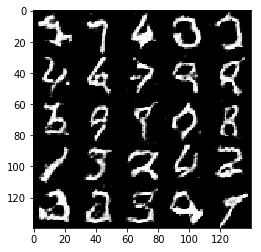

Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 1.6580
Epoch 1/2... Discriminator Loss: 0.6472... Generator Loss: 1.6112
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 0.8445... Generator Loss: 1.1271
Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 1.6966
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 0.6574... Generator Loss: 1.6593
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 1.8534
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.6839


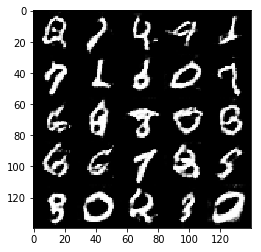

Epoch 1/2... Discriminator Loss: 0.6925... Generator Loss: 1.5233
Epoch 1/2... Discriminator Loss: 0.7736... Generator Loss: 1.1585
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.1609
Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 2.0234
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 0.8746
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.6728
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.6703
Epoch 1/2... Discriminator Loss: 0.4980... Generator Loss: 2.2536


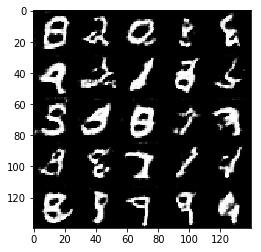

Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 0.5481... Generator Loss: 2.5096
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 1.5499
Epoch 1/2... Discriminator Loss: 0.5319... Generator Loss: 2.3784
Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 1.3769
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 1.6912
Epoch 1/2... Discriminator Loss: 0.8132... Generator Loss: 1.1226
Epoch 1/2... Discriminator Loss: 0.8115... Generator Loss: 1.1135


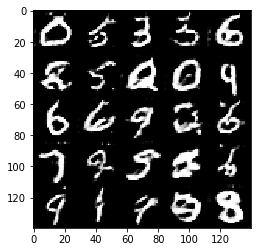

Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 1.5455
Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 1.2305
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 1.7806
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.3285
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 2.2976
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.7671
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.9541
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 1.4083
Epoch 1/2... Discriminator Loss: 1.7228... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 1.7814


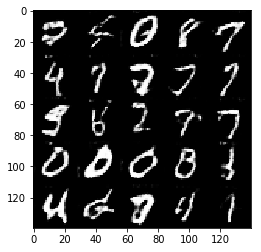

Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 1.8032
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 1.5821
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 1.0685
Epoch 1/2... Discriminator Loss: 0.7736... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 1.7080
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 0.7363... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.1588
Epoch 1/2... Discriminator Loss: 0.6240... Generator Loss: 1.6364
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 0.7466


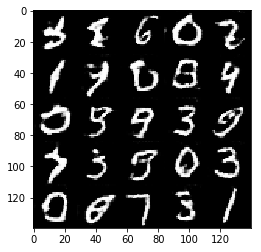

Epoch 1/2... Discriminator Loss: 0.5831... Generator Loss: 2.2598
Epoch 1/2... Discriminator Loss: 0.7079... Generator Loss: 1.4567
Epoch 1/2... Discriminator Loss: 0.7206... Generator Loss: 1.6819
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 3.5381
Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 1.3866
Epoch 2/2... Discriminator Loss: 0.5807... Generator Loss: 1.8369
Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 1.0970
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 0.7304
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.3967
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.1516
Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.0933
Epoch 2/2... Discriminator Loss: 0.6927... Generator Loss: 1.6854
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.6815


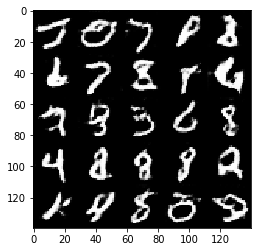

Epoch 2/2... Discriminator Loss: 1.0424... Generator Loss: 1.0172
Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.6008
Epoch 2/2... Discriminator Loss: 0.6122... Generator Loss: 1.6120
Epoch 2/2... Discriminator Loss: 0.7120... Generator Loss: 1.4168
Epoch 2/2... Discriminator Loss: 0.6993... Generator Loss: 1.3940
Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 1.7176
Epoch 2/2... Discriminator Loss: 0.5081... Generator Loss: 2.3318
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 0.5800... Generator Loss: 1.6840
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 0.7568


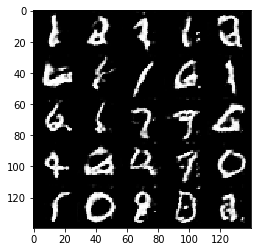

Epoch 2/2... Discriminator Loss: 0.5637... Generator Loss: 1.9058
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 0.8034... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 0.6283... Generator Loss: 1.5235
Epoch 2/2... Discriminator Loss: 1.4617... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 1.5994... Generator Loss: 0.4287
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.7124
Epoch 2/2... Discriminator Loss: 0.6594... Generator Loss: 1.5367
Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 1.8492
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 1.0685


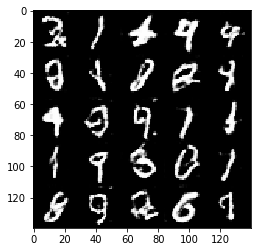

Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 1.0964
Epoch 2/2... Discriminator Loss: 0.5786... Generator Loss: 1.8172
Epoch 2/2... Discriminator Loss: 0.6380... Generator Loss: 1.5685
Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 1.7710
Epoch 2/2... Discriminator Loss: 1.9306... Generator Loss: 0.3363
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.5162
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 1.8051
Epoch 2/2... Discriminator Loss: 0.5441... Generator Loss: 2.0502
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 1.5379


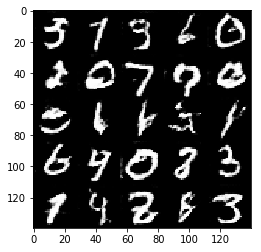

Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 1.9031
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.9272
Epoch 2/2... Discriminator Loss: 0.4874... Generator Loss: 2.2855
Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 2.4239
Epoch 2/2... Discriminator Loss: 0.6093... Generator Loss: 1.6336
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 4.0874
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 1.1593
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 1.4908
Epoch 2/2... Discriminator Loss: 0.5830... Generator Loss: 1.8439
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 0.8782


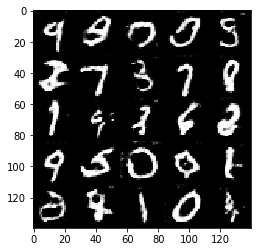

Epoch 2/2... Discriminator Loss: 2.7766... Generator Loss: 0.1441
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 0.7558
Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.6714
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 1.3424
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 1.5735
Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 0.6350... Generator Loss: 1.5806
Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 1.6340
Epoch 2/2... Discriminator Loss: 0.4439... Generator Loss: 2.6229


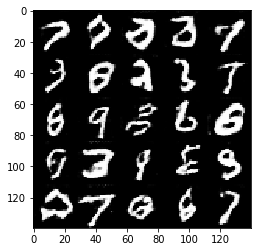

Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.6570
Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 3.1433
Epoch 2/2... Discriminator Loss: 0.6844... Generator Loss: 1.3758
Epoch 2/2... Discriminator Loss: 0.4303... Generator Loss: 2.8276
Epoch 2/2... Discriminator Loss: 0.7292... Generator Loss: 1.3962
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.1637
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.8010
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.7393
Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 1.7742


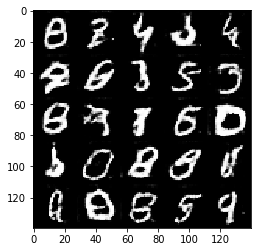

Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.1772
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 3.0384
Epoch 2/2... Discriminator Loss: 0.6115... Generator Loss: 2.5339
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 2.8779
Epoch 2/2... Discriminator Loss: 0.9068... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 0.6724... Generator Loss: 1.4137
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 0.6173... Generator Loss: 1.6320
Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 1.6251


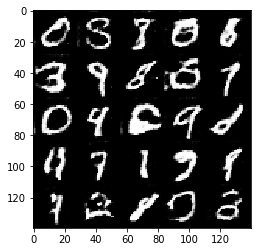

Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.0189
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.7192
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 0.5532... Generator Loss: 2.0868
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.2378
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 1.7203
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.7409... Generator Loss: 0.3851


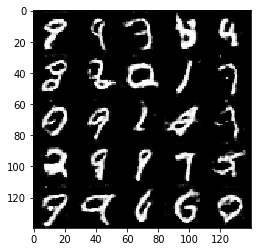

Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.2333
Epoch 2/2... Discriminator Loss: 0.5080... Generator Loss: 2.7076
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.5345
Epoch 2/2... Discriminator Loss: 0.5870... Generator Loss: 1.6886
Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.7727
Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 1.0994
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 1.1674
Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.5921
Epoch 2/2... Discriminator Loss: 0.7072... Generator Loss: 1.3090


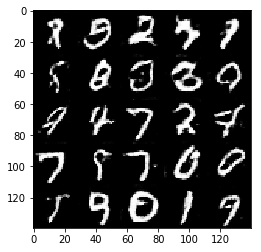

Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.4962
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.6313
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.5922
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 0.4617... Generator Loss: 3.0387
Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 1.6550
Epoch 2/2... Discriminator Loss: 1.5761... Generator Loss: 0.4192
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 2.2363
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 0.8701... Generator Loss: 1.0357


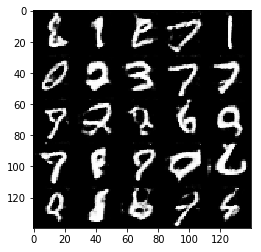

Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.4198
Epoch 2/2... Discriminator Loss: 0.5425... Generator Loss: 1.9774
Epoch 2/2... Discriminator Loss: 0.5537... Generator Loss: 2.0868
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.2790
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 0.8602
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.1644
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.4205
Epoch 2/2... Discriminator Loss: 0.5507... Generator Loss: 2.1686


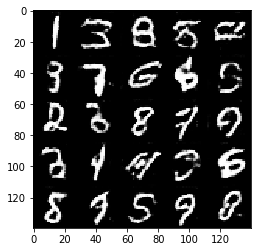

Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 1.1777
Epoch 2/2... Discriminator Loss: 0.5309... Generator Loss: 2.4011
Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.3654
Epoch 2/2... Discriminator Loss: 0.7703... Generator Loss: 1.2185
Epoch 2/2... Discriminator Loss: 0.4509... Generator Loss: 2.8763
Epoch 2/2... Discriminator Loss: 0.5630... Generator Loss: 1.9280
Epoch 2/2... Discriminator Loss: 0.5101... Generator Loss: 2.1958
Epoch 2/2... Discriminator Loss: 1.5119... Generator Loss: 0.5465
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.1879
Epoch 2/2... Discriminator Loss: 0.6612... Generator Loss: 1.6274


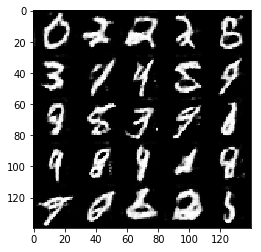

Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.0863
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.5023
Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.5756
Epoch 2/2... Discriminator Loss: 0.4856... Generator Loss: 2.3296
Epoch 2/2... Discriminator Loss: 0.5545... Generator Loss: 1.9035
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 1.8858
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.7225... Generator Loss: 0.4720


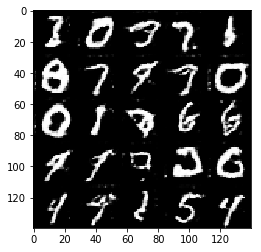

Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.3495
Epoch 2/2... Discriminator Loss: 0.6122... Generator Loss: 1.5234
Epoch 2/2... Discriminator Loss: 0.5499... Generator Loss: 2.0880
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 2.8775
Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.5990
Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 0.9544
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 1.0580
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.5160
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 1.2355
Epoch 2/2... Discriminator Loss: 0.7078... Generator Loss: 1.2840


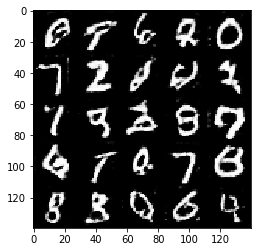

Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.6843
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 0.6751... Generator Loss: 1.5684
Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 1.9704
Epoch 2/2... Discriminator Loss: 0.6394... Generator Loss: 1.5274
Epoch 2/2... Discriminator Loss: 0.7124... Generator Loss: 1.2758
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 1.3042
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 2.1349
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 1.7166
Epoch 2/2... Discriminator Loss: 0.9032... Generator Loss: 1.0371


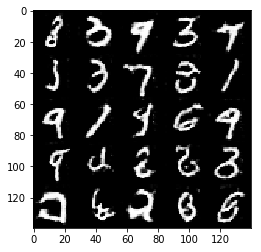

Epoch 2/2... Discriminator Loss: 0.7325... Generator Loss: 2.5316
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.2118
Epoch 2/2... Discriminator Loss: 0.8165... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 1.5470
Epoch 2/2... Discriminator Loss: 0.4185... Generator Loss: 3.3229
Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 1.5798
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 0.7617... Generator Loss: 1.4789
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.6989
Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.7737


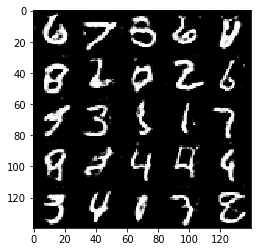

Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 2.0958
Epoch 2/2... Discriminator Loss: 0.5283... Generator Loss: 1.9949
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 2.9288
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 1.6339
Epoch 2/2... Discriminator Loss: 0.6010... Generator Loss: 1.7534
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.2746
Epoch 2/2... Discriminator Loss: 0.6204... Generator Loss: 1.7391
Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 1.2927


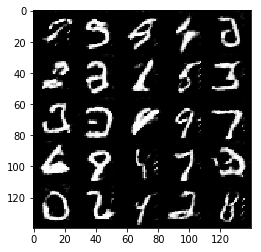

Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 1.3897
Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.3218
Epoch 2/2... Discriminator Loss: 0.5861... Generator Loss: 1.7938
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.0036
Epoch 2/2... Discriminator Loss: 0.4775... Generator Loss: 2.4639
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.3545
Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 1.8178
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 1.4635
Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 1.3160
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.2472


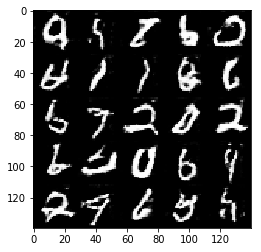

Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.2078
Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 1.2160
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 3.7605
Epoch 2/2... Discriminator Loss: 0.4984... Generator Loss: 2.3719
Epoch 2/2... Discriminator Loss: 0.5775... Generator Loss: 1.7498
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.3085
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 3.0828
Epoch 2/2... Discriminator Loss: 0.5133... Generator Loss: 2.5397
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 0.8866
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.6246


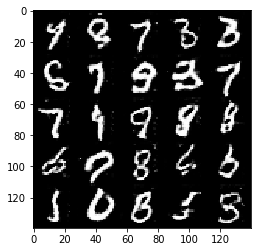

Epoch 2/2... Discriminator Loss: 0.5819... Generator Loss: 1.8386
Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 1.3456
Epoch 2/2... Discriminator Loss: 0.6322... Generator Loss: 1.5677
Epoch 2/2... Discriminator Loss: 0.5891... Generator Loss: 1.9114
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 2.8427
Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 2.7494
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 0.5163... Generator Loss: 1.9878
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 1.5078
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 0.8966


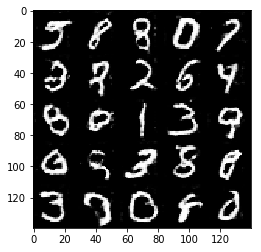

Epoch 2/2... Discriminator Loss: 0.4741... Generator Loss: 2.4386
Epoch 2/2... Discriminator Loss: 1.5630... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 1.4295
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 1.0653
Epoch 2/2... Discriminator Loss: 0.6945... Generator Loss: 2.8136
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 2.1682
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 1.3548
Epoch 2/2... Discriminator Loss: 0.4676... Generator Loss: 2.4921
Epoch 2/2... Discriminator Loss: 0.5087... Generator Loss: 2.2107
Epoch 2/2... Discriminator Loss: 0.4922... Generator Loss: 2.2738


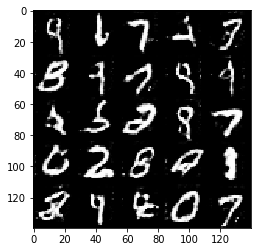

Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.0904
Epoch 2/2... Discriminator Loss: 0.6119... Generator Loss: 1.6710
Epoch 2/2... Discriminator Loss: 0.5738... Generator Loss: 2.0821
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 1.1412
Epoch 2/2... Discriminator Loss: 1.5442... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 1.1772
Epoch 2/2... Discriminator Loss: 0.5756... Generator Loss: 2.1098
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 1.9126
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 1.6883
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.0998


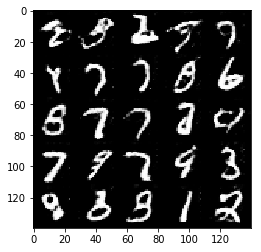

Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 1.7567
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 2.2641
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.5654... Generator Loss: 1.8988
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 1.4859
Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 1.3354
Epoch 2/2... Discriminator Loss: 0.5699... Generator Loss: 1.8996
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 0.9269


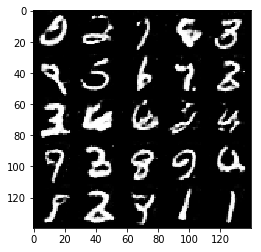

Epoch 2/2... Discriminator Loss: 0.5282... Generator Loss: 2.0513
Epoch 2/2... Discriminator Loss: 0.6291... Generator Loss: 1.6084
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.2290
Epoch 2/2... Discriminator Loss: 0.4867... Generator Loss: 2.1122
Epoch 2/2... Discriminator Loss: 0.6558... Generator Loss: 1.4959
Epoch 2/2... Discriminator Loss: 0.4625... Generator Loss: 2.3749
Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 0.9193
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.4390
Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.4499
Epoch 2/2... Discriminator Loss: 0.5693... Generator Loss: 1.7767


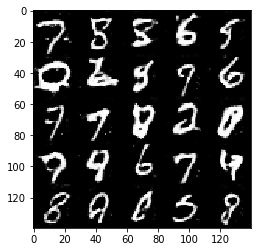

Epoch 2/2... Discriminator Loss: 0.5920... Generator Loss: 1.6532
Epoch 2/2... Discriminator Loss: 2.0521... Generator Loss: 0.2675
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 1.3264
Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 2.1547
Epoch 2/2... Discriminator Loss: 0.5530... Generator Loss: 2.2605
Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 2.1619
Epoch 2/2... Discriminator Loss: 2.1650... Generator Loss: 0.3039
Epoch 2/2... Discriminator Loss: 0.6304... Generator Loss: 1.7785
Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.4375
Epoch 2/2... Discriminator Loss: 0.4918... Generator Loss: 2.2230


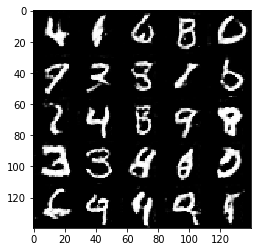

Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 1.3677
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.5442
Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 1.5756
Epoch 2/2... Discriminator Loss: 0.5060... Generator Loss: 2.0919
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.8324
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 1.4752
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 1.7129
Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.2145
Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 1.5389


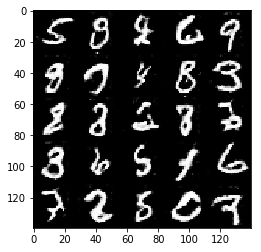

Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 1.9847
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 3.3124
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.8854
Epoch 2/2... Discriminator Loss: 0.6621... Generator Loss: 1.5339
Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 2.7919
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.3076
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.4513
Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 2.4726
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.5691


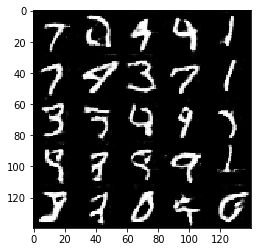

Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.2684
Epoch 2/2... Discriminator Loss: 0.6237... Generator Loss: 1.7539
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 3.2808
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 3.0787
Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 1.3816
Epoch 2/2... Discriminator Loss: 0.7905... Generator Loss: 1.1195
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 2.0413
Epoch 2/2... Discriminator Loss: 0.5131... Generator Loss: 2.0102
Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 1.5668
Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 1.7326


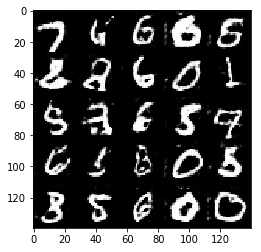

Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 2.0030
Epoch 2/2... Discriminator Loss: 0.4431... Generator Loss: 2.6685
Epoch 2/2... Discriminator Loss: 0.4020... Generator Loss: 2.9819
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 3.5734
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 0.9457
Epoch 2/2... Discriminator Loss: 0.6075... Generator Loss: 1.8317
Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 1.3453
Epoch 2/2... Discriminator Loss: 0.5690... Generator Loss: 1.8997
Epoch 2/2... Discriminator Loss: 0.6667... Generator Loss: 1.4597
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 1.3978


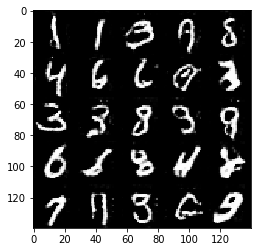

Epoch 2/2... Discriminator Loss: 0.4851... Generator Loss: 2.1712
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 1.7869
Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.5494
Epoch 2/2... Discriminator Loss: 0.4827... Generator Loss: 2.2158
Epoch 2/2... Discriminator Loss: 0.5131... Generator Loss: 2.0254
Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 2.6763
Epoch 2/2... Discriminator Loss: 0.6083... Generator Loss: 1.6052
Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 1.7907
Epoch 2/2... Discriminator Loss: 0.6117... Generator Loss: 1.5368
Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 1.9477


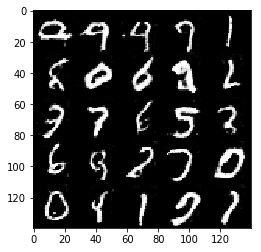

Epoch 2/2... Discriminator Loss: 0.6227... Generator Loss: 1.6344
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.3838
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 1.5284
Epoch 2/2... Discriminator Loss: 1.6396... Generator Loss: 1.0916
Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 1.7256
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.9941
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 2.0721
Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.3153
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 1.0286


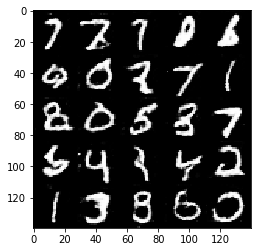

Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 1.1552
Epoch 2/2... Discriminator Loss: 0.5864... Generator Loss: 1.7091
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.1024
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 1.8112
Epoch 2/2... Discriminator Loss: 0.4903... Generator Loss: 2.2710
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 0.5865
Epoch 2/2... Discriminator Loss: 0.5110... Generator Loss: 2.1219
Epoch 2/2... Discriminator Loss: 0.5880... Generator Loss: 2.4262
Epoch 2/2... Discriminator Loss: 0.6075... Generator Loss: 1.8320
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 1.4528


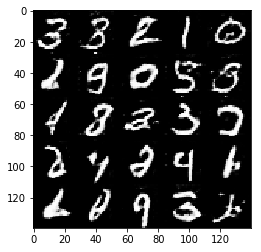

Epoch 2/2... Discriminator Loss: 0.4156... Generator Loss: 2.7440
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.5657
Epoch 2/2... Discriminator Loss: 0.6632... Generator Loss: 1.4490
Epoch 2/2... Discriminator Loss: 0.6025... Generator Loss: 1.7126
Epoch 2/2... Discriminator Loss: 0.5580... Generator Loss: 1.7494
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.4082
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.6569
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 2.6774


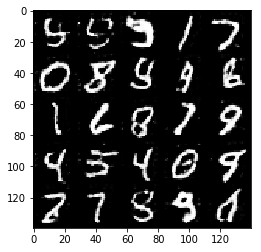

Epoch 2/2... Discriminator Loss: 0.5692... Generator Loss: 1.6957
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.5918
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.8926
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 1.2525
Epoch 2/2... Discriminator Loss: 0.5981... Generator Loss: 2.0360
Epoch 2/2... Discriminator Loss: 0.5734... Generator Loss: 1.7372
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 2.2875
Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 2.1629
Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.6212
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 1.3102


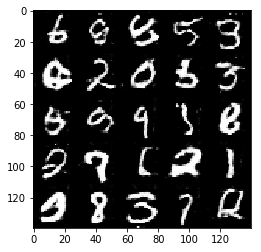

Epoch 2/2... Discriminator Loss: 0.5618... Generator Loss: 1.8625
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 1.0690
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 1.7966
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.5872
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.5865
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 3.0186
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.3439
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.3941


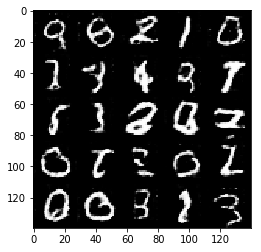

Epoch 2/2... Discriminator Loss: 0.5321... Generator Loss: 1.8790
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.2650
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.7048
Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 0.4798... Generator Loss: 2.6014
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.2549
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.9168
Epoch 2/2... Discriminator Loss: 0.4671... Generator Loss: 2.6590


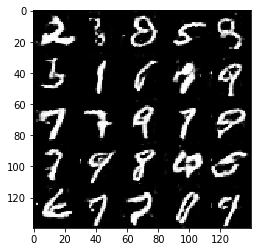

Epoch 2/2... Discriminator Loss: 0.5759... Generator Loss: 2.3375
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 0.6352... Generator Loss: 1.5200
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 1.8749
Epoch 2/2... Discriminator Loss: 0.5804... Generator Loss: 1.6089


In [90]:
batch_size = 16 #using a very low batch size as the generator needs to cope with the discriminator
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9329... Generator Loss: 0.3608
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 2.6928... Generator Loss: 0.1590
Epoch 1/1... Discriminator Loss: 2.5469... Generator Loss: 0.1748
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.6252
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.4210


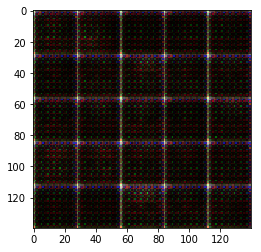

Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 2.5533
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.5678
Epoch 1/1... Discriminator Loss: 1.8564... Generator Loss: 0.3335
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 1.3873
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.7629... Generator Loss: 3.1655
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.9321


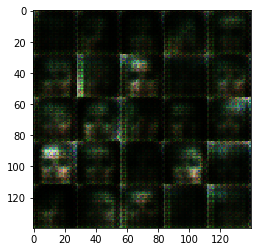

Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.7916
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.4097
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7984


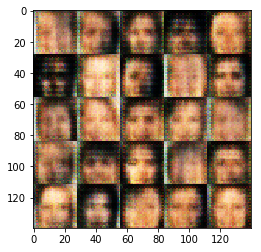

Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9833


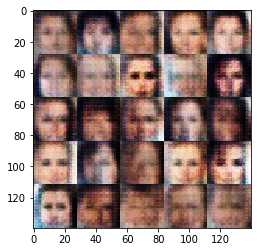

Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.5022
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.3085
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.2947
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6744


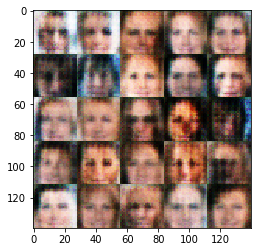

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.9225... Generator Loss: 0.3122
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.9851


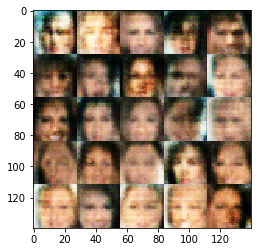

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.7360... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 1.0837


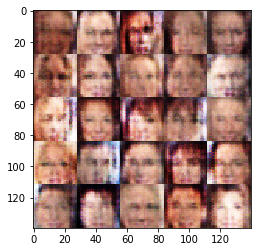

Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.6372... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6760


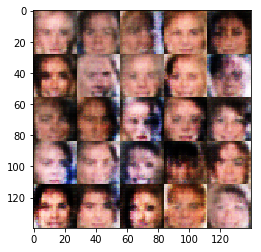

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8159


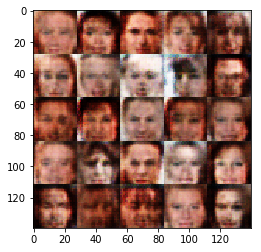

Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.9368


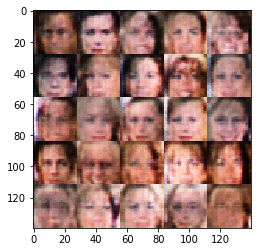

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 1.0849


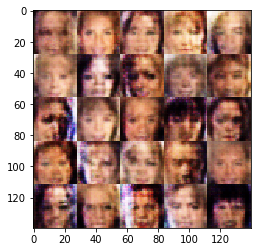

Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6084


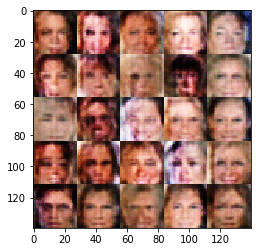

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6648


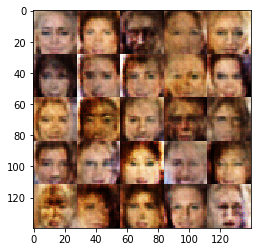

Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8140


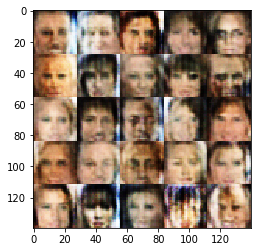

Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8353


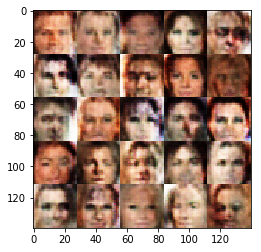

Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.0309


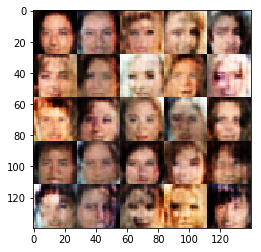

Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 1.3949
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8905


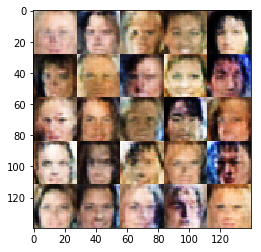

Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7096


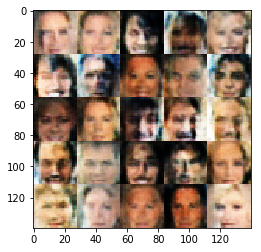

Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6897


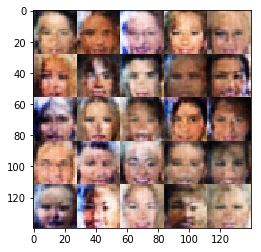

Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.8832


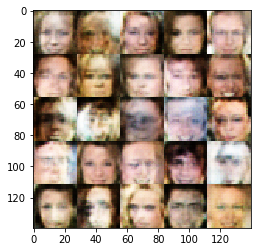

Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8204


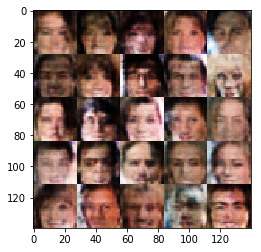

Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.3142
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.0063


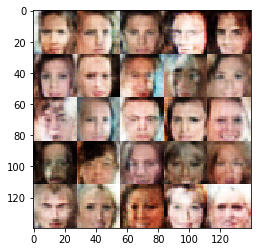

Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.8874... Generator Loss: 0.2655
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8653


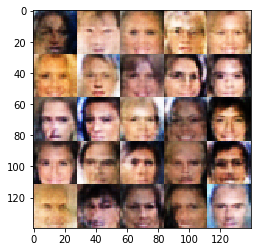

Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7300


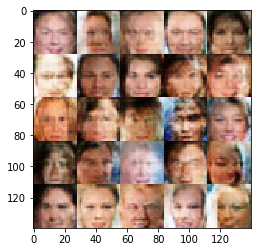

Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7890


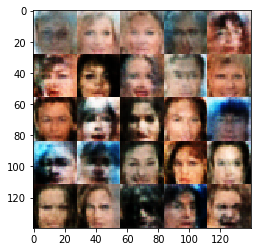

Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.4517


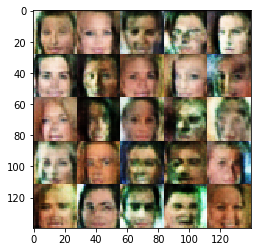

Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.8936


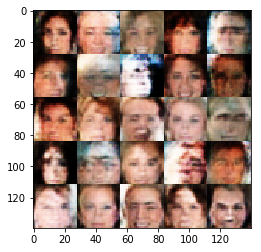

Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.3019


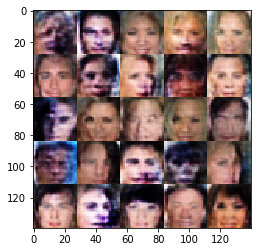

Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.3425
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7480


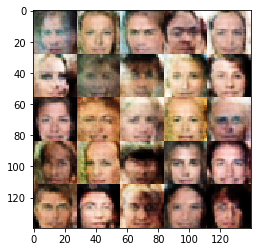

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9859


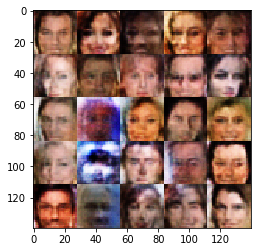

Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.5832


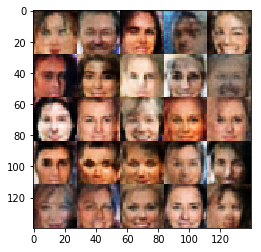

Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.2249


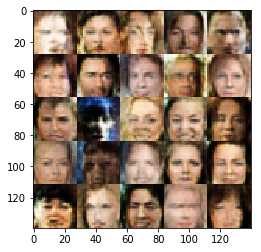

Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.5443


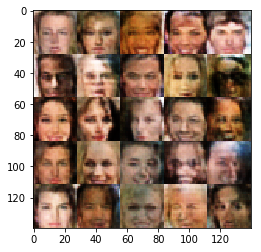

Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 0.4155
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.9444


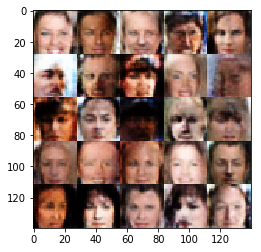

Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.6391
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6000


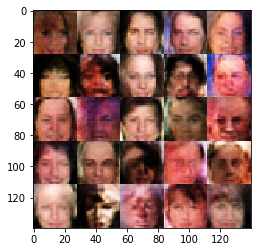

Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.8813


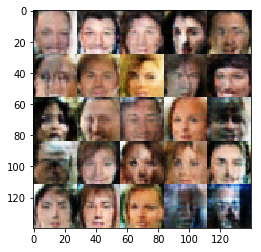

Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.3827


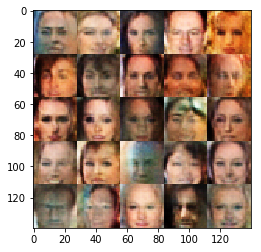

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.9488


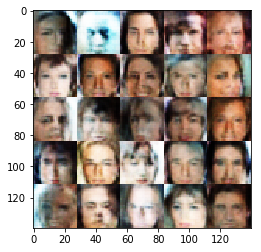

Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7185


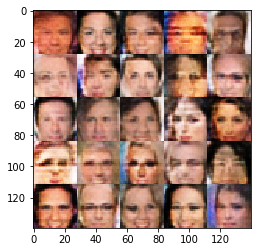

Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.4911


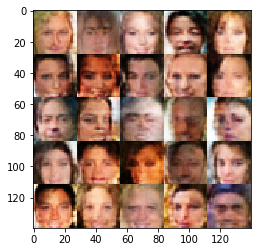

Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7938


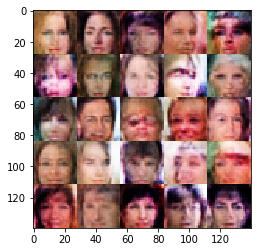

Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.9438


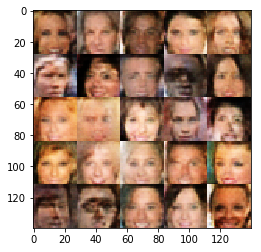

Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.3976


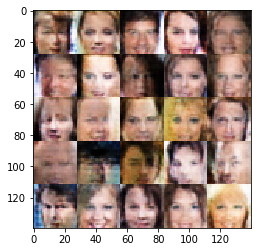

Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9830


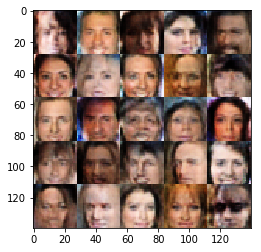

Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 2.1830... Generator Loss: 0.2366
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.2556


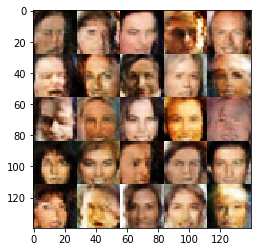

Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.6495


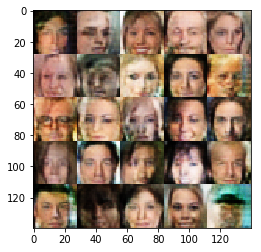

Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.9867


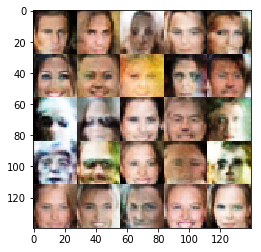

Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.4413
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.9649


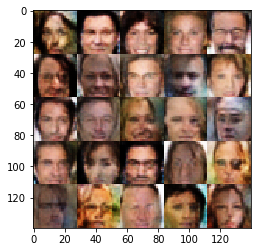

Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.5140


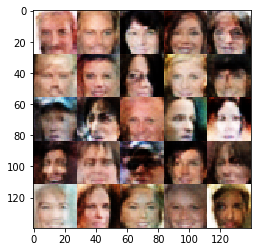

Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 1.3267
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.2564
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7438


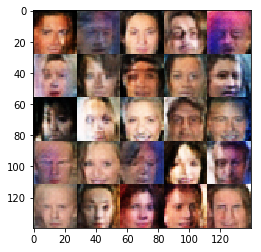

Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.8632


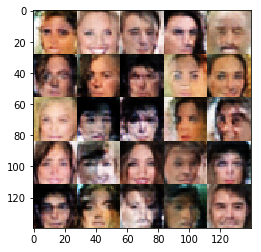

Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.9335


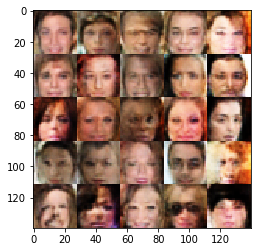

Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.8621


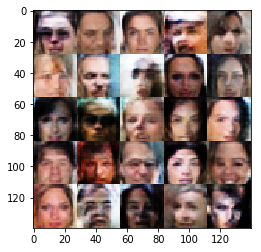

Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6997


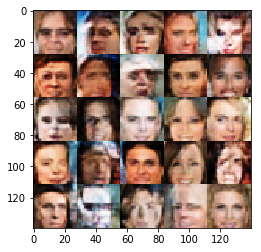

Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6828


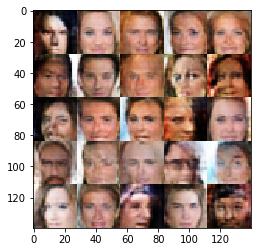

Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.6925


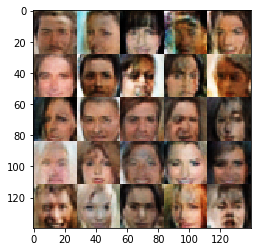

Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.7028... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.3466


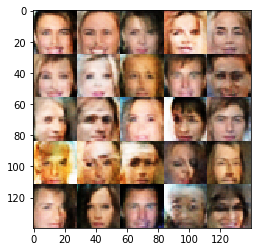

Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.2862
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.5774


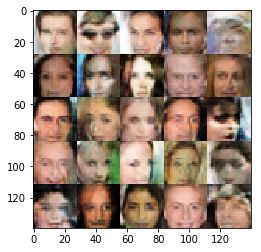

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.5824


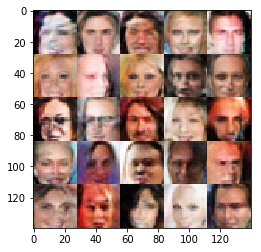

Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 1.2303


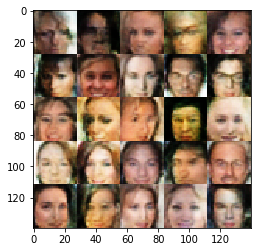

Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9209


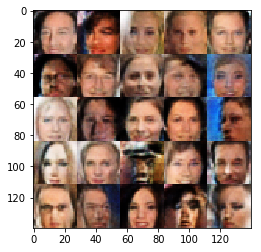

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8587


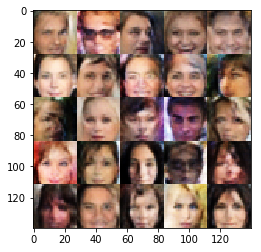

Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7836


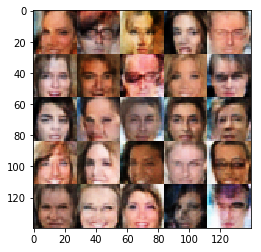

Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.7207


In [91]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.